In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [30]:
summary = pd.read_csv("garmin_edge_820/summary.csv")   
details = pd.read_csv("garmin_edge_820/4557226804_ACTIVITY_data.csv", sep=";")

In [31]:
details.rename(columns=lambda x: x.replace('record.', ''), inplace=True)
details['time'] = pd.to_datetime(details.pop('timestamp[s]'), unit='s').dt.time
details.set_index("time", inplace=True)

In [32]:
hr_zones = [(0, 128), (129, 146), (147, 156), (157, 165), (166, 174), (175, 179), (180, float('inf'))]
power_zones = [(0, 157), (158, 186), (187, 200), (201, 218), (219, 247), (248, 287), (288, float('inf'))]
# funzione che calcola le zone di frequenza cardiaca dato il battito in input

def get_zone(rate, zones):
    for zone, (lower, upper) in enumerate(zones, start=1):
        if lower <= rate <= upper:
            return zone

In [33]:
details['hr_zone'] = details['heart_rate[bpm]'].apply(get_zone, zones=hr_zones)
details['pwr_zone'] = details['power[watts]'].apply(get_zone, zones=power_zones)

In [34]:
details['time_since_start'] = 1
details['time_since_start'] = details['time_since_start'].cumsum().sub(1)

In [35]:
# Calcola la differenza di altitudine tra le righe adiacenti
details['altitude_diff'] = details['altitude[m]'] - details['altitude[m]'].shift(1)
details['distance_diff'] = details['distance[m]'] - details['distance[m]'].shift(1)
details[['altitude_diff', 'distance_diff']] = details[['altitude_diff', 'distance_diff']].fillna(0)

# Calcola la percentuale di pendenza
details['slope_percent'] = np.where(details['distance_diff'] == 0, 0, details['altitude_diff'] / details['distance_diff'] * 100)

In [36]:
details.dtypes

distance[m]                        float64
accumulated_power[watts]             int64
altitude[m]                        float64
speed[m/s]                         float64
power[watts]                         int64
heart_rate[bpm]                      int64
cadence[rpm]                         int64
temperature[C]                       int64
left_right_balance                   int64
left_pco[mm]                         int64
right_pco[mm]                        int64
left_power_phase[degrees]           object
left_power_phase_peak[degrees]      object
right_power_phase[degrees]          object
right_power_phase_peak[degrees]     object
hr_zone                              int64
pwr_zone                             int64
time_since_start                     int64
altitude_diff                      float64
distance_diff                      float64
slope_percent                      float64
dtype: object

In [37]:
details.isna().sum()

distance[m]                        0
accumulated_power[watts]           0
altitude[m]                        0
speed[m/s]                         1
power[watts]                       0
heart_rate[bpm]                    0
cadence[rpm]                       0
temperature[C]                     0
left_right_balance                 0
left_pco[mm]                       0
right_pco[mm]                      0
left_power_phase[degrees]          0
left_power_phase_peak[degrees]     0
right_power_phase[degrees]         0
right_power_phase_peak[degrees]    0
hr_zone                            0
pwr_zone                           0
time_since_start                   0
altitude_diff                      0
distance_diff                      0
slope_percent                      0
dtype: int64

In [38]:
details['speed[m/s]'] = details['speed[m/s]'].fillna(details['speed[m/s]'].mean()) 

### Data Visualization

<Axes: xlabel='heart_rate[bpm]', ylabel='cadence[rpm]'>

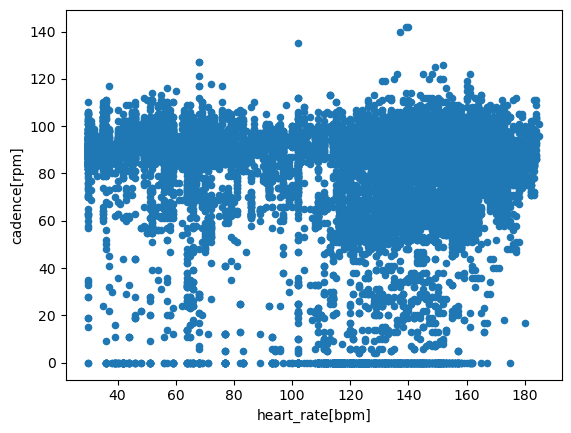

In [39]:
details.plot.scatter(y="cadence[rpm]", x="heart_rate[bpm]")

<Axes: xlabel='time_since_start'>

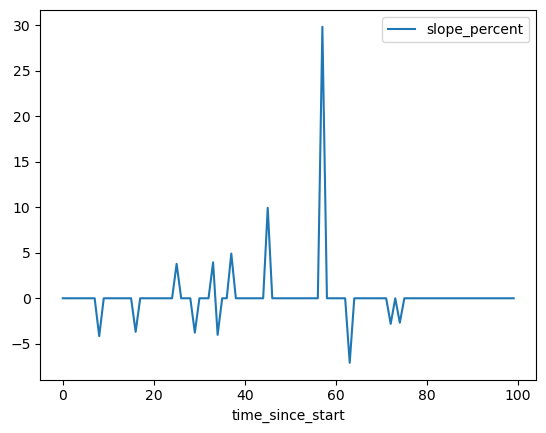

In [40]:
details.head(100).plot.line(x='time_since_start', y='slope_percent')

### Models

In [41]:
X = details.drop(['left_power_phase[degrees]', 
                  'left_power_phase_peak[degrees]', 
                  'right_power_phase[degrees]', 
                  'right_power_phase_peak[degrees]', 
                  'heart_rate[bpm]'], axis=1)
y = details['heart_rate[bpm]']


In [45]:
from sklearn.metrics import mean_squared_error, r2_score

# definisco l'errore relativo
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
from sklearn.linear_model import LinearRegression
lrm = LinearRegression()
lrm.fit(X_train, y_train)
print_eval(X_val, y_val, lrm)

   Mean squared error: 183.03
       Relative error: 11.03527%
R-squared coefficient: 0.88208


In [56]:
from sklearn.linear_model import Lasso
lsm = Lasso(alpha=0.3)
lsm.fit(X_train, y_train)
print_eval(X_val, y_val, lsm)

   Mean squared error: 183.98
       Relative error: 11.06330%
R-squared coefficient: 0.88146


/opt/anaconda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e+06, tolerance: 2.546e+03
  model = cd_fast.enet_coordinate_descent(


In [57]:
from sklearn.linear_model import Ridge
rrm = Ridge(alpha=0.5)
rrm.fit(X_train, y_train)
print_eval(X_val, y_val, rrm)

   Mean squared error: 183.03
       Relative error: 11.03530%
R-squared coefficient: 0.88208


In [59]:
pd.DataFrame({
    "linear": lrm.coef_,
    "ridge": rrm.coef_,
    "lasso": lsm.coef_
}, index=X_train.columns)

,linear,ridge,lasso
distance[m],-0.002392,-0.002392,-0.002187
accumulated_power[watts],0.000130,0.000130,0.000107
altitude[m],-0.030684,-0.030684,-0.022686
speed[m/s],1.364711,1.364583,1.013341
power[watts],0.011910,0.011908,0.002125
cadence[rpm],-0.041070,-0.041062,-0.027279
temperature[C],2.419016,2.419036,2.312895
left_right_balance,0.008089,0.008091,0.007438
left_pco[mm],0.011945,0.011956,0.001202
right_pco[mm],-0.177860,-0.177864,-0.153518
